### Packages and dataset

In [62]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew,boxcox,yeojohnson
from bayes_opt import BayesianOptimization
from sklearn.preprocessing import LabelEncoder
import category_encoders
from category_encoders.target_encoder import TargetEncoder
from sklearn.model_selection import train_test_split,cross_val_score,KFold,GridSearchCV,cross_validate
from sklearn.preprocessing import StandardScaler
import time
from sklearn.metrics import roc_auc_score,roc_curve, auc,precision_score,recall_score, precision_recall_curve,plot_precision_recall_curve,accuracy_score,plot_confusion_matrix,confusion_matrix,classification_report
from sklearn.ensemble import RandomForestClassifier,StackingClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.svm import SVC
import matplotlib.pyplot as plt

# From previous checpoints

In [63]:
#Reading csv
df = pd.read_csv("bank_marketing_weka_dataset.csv")

#Separate features
X = df.drop(['y'], axis=1)

#Target variable
y = df['y']

#Transform 'y' to binary
y = y.map(dict(yes=1, no=0))

#Continuos variables
conti = X.select_dtypes(include=np.number)

### Target variable balance

In [64]:
y.value_counts()

0    4000
1     521
Name: y, dtype: int64

### Features engineering

### Modifications for the whole dataset

In [65]:
X = X.replace('yes', 1)
X = X.replace('no', 0)

In [66]:
X.month = X.month.map(dict(
jan=1, feb=2, mar=3, apr=4, may=5, jun=6,
jul=7, aug=8, sep=9, oct=10, nov=11, dec=12))

### Train test split
Now we split the dataset to train and test parts to prevent data leakage in the future model learning.  
We use stratify parameter to keep equal proportions between classes. 

In [67]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state = 42,stratify=y)

### Continuous variables

### Train set

In [68]:
def skew(X, conti):
    '''Calculates skewness of continuous variables in dataset. conti - var list
    returns columns with skewness>2'''
    skewed = []
    for column in conti.columns:
        if conti[column].skew()>2:
            skewed.append(column)
        print(f'{column.capitalize()} skew = {conti[column].skew()}')
    return(skewed)

In [69]:
skew_train = skew(X_train, conti)

Age skew = 0.6995014533559305
Balance skew = 6.596430546295735
Day skew = 0.09462690455175846
Duration skew = 2.7724197169136455
Campaign skew = 4.74391446894159
Pdays skew = 2.71707136656418
Previous skew = 5.875258677896706


In [70]:
def skew_reduce(X, skewed):
    '''Applies boxcox or yeojohnson transform on skew vars'''
    for column in skewed:
        if X[column].min()>0:
            print(pd.Series(boxcox(X[column])[0]).skew(),f'{column} boxcox')
            X.reset_index(drop=True, inplace=True)
            X.loc[:, column] = pd.Series(boxcox(X[column])[0])
        else:
            print(pd.Series(yeojohnson(X[column])[0]).skew(),f'{column} yeojohnson')
            X.reset_index(drop=True, inplace=True)
            X.loc[:, column] = pd.Series(yeojohnson(X[column])[0])

In [71]:
skew_reduce(X_train, skew_train)

1.1384912322328207 balance yeojohnson
0.013257465607195186 duration boxcox
0.16296521851854104 campaign boxcox
1.633351627582676 pdays yeojohnson
1.6323338862831511 previous yeojohnson


### Test set

In [72]:
skew_test = skew(X_test, conti)

Age skew = 0.6995014533559305
Balance skew = 6.596430546295735
Day skew = 0.09462690455175846
Duration skew = 2.7724197169136455
Campaign skew = 4.74391446894159
Pdays skew = 2.71707136656418
Previous skew = 5.875258677896706


In [73]:
skew_reduce(X_test, skew_test)

2.28515105202657 balance yeojohnson
0.021053668359760105 duration boxcox
0.17031430500454864 campaign boxcox
1.7444746397142898 pdays yeojohnson
1.7458862134772606 previous yeojohnson


### Categorical variables

### Variables: 'job', 'marital', 'education', 'poutcom', 'contact'

In [74]:
#Approach 1 which achived better results in last experiments
X1_train = X_train.copy()
X1_test = X_test.copy()

#Target encoding train set
te = TargetEncoder()
X1_train.loc[:, ['job', 'education', 'poutcome']] = te.fit_transform(X1_train.loc[:, ['job', 'education', 'poutcome']], y_train)
#test set
X1_test.loc[:, ['job', 'education', 'poutcome']] = te.transform(X1_test.loc[:, ['job', 'education', 'poutcome']])

#One-hot encoding
X1_train = pd.get_dummies(X1_train, columns=['marital', 'contact'])
X1_test = pd.get_dummies(X1_test, columns=['marital', 'contact'])

#For future
cols = X1_train.columns

In [75]:
scaler = StandardScaler()
X1_train = scaler.fit_transform(X1_train)
X1_test = scaler.transform(X1_test)

### Modeling

In [76]:
def modeling(X_train, y_train):
        #cv folds,
        kfold = KFold(n_splits=5, random_state=42, shuffle=True)
        scoring = {'precision': 'precision_macro',
                   'recall': 'recall_macro',
                   'accuracy': 'accuracy',
                   'auc': 'roc_auc'}
        
        #Logistic regression"
        logistic =  LogisticRegression(C=0.001,solver='saga',random_state=42)
        r_log = cross_validate(logistic,X_train,y_train,scoring=scoring, cv=kfold)
        
        #xgb
        params = {'colsample_bytree': 0.8, 'gamma': 1.5, 'max_depth': 4, 'min_child_weight': 1, 
                  'subsample': 0.8,'n_estimators':400,'random_state':42}
        xg = xgb.XGBClassifier(objective='binary:logistic',nthread=4,n_jobs=4,params=params)
        r_xgb = cross_validate(xg, X_train, y_train, cv=kfold, scoring=scoring)
        
        #random forest
        params = {'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 2, 
                  'n_estimators': 500,'max_features':'auto','random_state':42}
        tree = RandomForestClassifier(**params)
        r_ranforest = cross_validate(tree,X_train,y_train,scoring=scoring,cv=kfold)
    
        svm = SVC(C=10)
        r_svm = cross_validate(svm,X_train,y_train,scoring=scoring,cv=kfold)
        
        return([r_log, r_ranforest, r_xgb,r_svm])

In [77]:
result = modeling(X1_train,y_train)

### Validation scores

Scores means from cross-validation are presented below for three tested algorithms and two features engineering approaches. We observe satisfying accuracy and auc, but recall needs to be improved in future. Its low score is propably caused by imbalance in target variable. Algorithms results are suprisingly very similar. XGBoost performed best in recall score.

In [78]:
r1 = pd.DataFrame(result[0]).mean()
r1.index = ['fit_time','score_time','validate_precision','validate_recall','validate_accuarcy','validate_auc']
r = pd.DataFrame({'X1': r1.values}, index=r1.axes)
r.drop(['fit_time','score_time'],inplace=True, level=0)
print("Logistic regression:")
r

Logistic regression:


,X1
validate_precision,0.442322
validate_recall,0.500000
validate_accuarcy,0.884645
validate_auc,0.843063


In [79]:
r1 = pd.DataFrame(result[1]).mean()
r1.index = ['fit_time','score_time','validate_precision','validate_recall','validate_accuarcy','validate_auc']
r = pd.DataFrame({'X1': r1.values}, index=r1.axes)
r.drop(['fit_time','score_time'],inplace=True, level=0)
print("Random forest:")
r

Random forest:


,X1
validate_precision,0.728527
validate_recall,0.512383
validate_accuarcy,0.886225
validate_auc,0.875942


In [80]:
r1 = pd.DataFrame(result[2]).mean()
r1.index = ['fit_time','score_time','validate_precision','validate_recall','validate_accuarcy','validate_auc']
r = pd.DataFrame({'X1': r1.values}, index=r1.axes)
r.drop(['fit_time','score_time'],inplace=True, level=0)
print("XGBoost:")
r

XGBoost:


,X1
validate_precision,0.761191
validate_recall,0.676092
validate_accuarcy,0.897911
validate_auc,0.889977


In [81]:
r1 = pd.DataFrame(result[3]).mean()
r1.index = ['fit_time','score_time','validate_precision','validate_recall','validate_accuarcy','validate_auc']
r = pd.DataFrame({'X1': r1.values}, index=r1.axes)
r.drop(['fit_time','score_time'],inplace=True, level=0)
print("SVM:")
r

SVM:


,X1
validate_precision,0.723144
validate_recall,0.643348
validate_accuarcy,0.888755
validate_auc,0.844012


# Final checkpoint

## Bayes optimization

We will use Bayes Optimization in order to get as good score as we can. We will focus on xgboost alghorithm.

In [82]:
pbounds = {'learning_rate': (0.01, 1.0), 'n_estimators': (100.0, 1000.0), 'max_depth': (4.0,10.0), 
           'subsample': (0.5, 1.0), 'colsample_bytree': (0.5, 1.0),'gamma': (0.0,5.0)}

def xgboost_hyper_param(learning_rate,n_estimators,max_depth,subsample,colsample_bytree,gamma):
    max_depth = int(max_depth)
    n_estimators = int(n_estimators)
    clf = xgb.XGBClassifier(max_depth=max_depth,learning_rate=learning_rate,n_estimators=n_estimators,
                            subsample=subsample,colsample_bytree=colsample_bytree,gamma=gamma)
    return np.mean(cross_val_score(clf, X1_train, y_train, cv=3, scoring='roc_auc'))

optimizer = BayesianOptimization(f=xgboost_hyper_param, pbounds=pbounds, random_state=1)
optimizer.maximize()
print('Final Results')
print(optimizer.max)

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | n_esti... | subsample |
-------------------------------------------------------------------------------------------------
|  1        |  0.8902   |  0.7085   |  3.602    |  0.01011  |  5.814    |  232.1    |  0.5462   |
|  2        |  0.8898   |  0.5931   |  1.728    |  0.4028   |  7.233    |  477.3    |  0.8426   |
|  3        |  0.9041   |  0.6022   |  4.391    |  0.03711  |  8.023    |  475.6    |  0.7793   |
|  4        |  0.8644   |  0.5702   |  0.9905   |  0.8027   |  9.81     |  382.1    |  0.8462   |
|  5        |  0.9002   |  0.9382   |  4.473    |  0.09419  |  4.234    |  252.8    |  0.9391   |
|  6        |  0.9006   |  1.0      |  5.0      |  0.01     |  10.0     |  1e+03    |  0.5      |
|  7        |  0.898    |  1.0      |  5.0      |  0.01     |  10.0     |  772.7    |  0.5      |
|  8        |  0.8651   |  0.9231   |  4.731    |  0.8683   |  5.227    |  100.4    |  0.8802   |
|  9        |  0.893

# Test dataset performance

In [83]:
def test(X_train,y_train,X_test,y_test):
        
        #Logistic regression
        logit = LogisticRegression(C=0.01,solver='saga',random_state=42)
        logit.fit(X_train,y_train)
        pred_log = logit.predict(X_test)
        precision_log = precision_score(y_test,pred_log,average='weighted')
        recall_log = recall_score(y_test,pred_log,average='weighted')
        accuracy = accuracy_score(y_test,pred_log)
        log_data = {'precision':precision_log,'recall': recall_log,'accuracy':accuracy}

        #xgb
        params ={'colsample_bytree': 0.6790427788825881, 'gamma': 4.9437121904855585, 
                 'learning_rate': 0.0686118272168518, 'max_depth': 9.907799344685499, 
                 'n_estimators': 456.4887419999514, 'subsample': 0.7791139392047272}
        xg = xgb.XGBClassifier(objective='binary:logistic',nthread=4,n_jobs=4,params=params)
        xg.fit(X_train,y_train)
        pred_xg = xg.predict(X_test)
        precision_xg = precision_score(y_test,pred_xg,average='weighted')
        recall_xg = recall_score(y_test,pred_xg,average='weighted')
        accuracy = accuracy_score(y_test,pred_xg)
        xg_data = {'precision':precision_xg,'recall': recall_xg,'accuracy':accuracy}
        
        #random forest
        params = {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2, 
                  'n_estimators': 1000, 'max_features':'auto'}
        tree = RandomForestClassifier(**params)
        tree.fit(X_train,y_train)
        pred_tree = tree.predict(X_test)
        precision_tree = precision_score(y_test,pred_tree,average='weighted')
        recall_tree = recall_score(y_test,pred_tree,average='weighted')
        accuracy = accuracy_score(y_test,pred_tree)
        tree_data = {'precision':precision_tree,'recall': recall_tree,'accuracy':accuracy}
        
        #SVM
        svm = SVC(C=10)
        svm.fit(X_train,y_train)
        pred_svm = svm.predict(X_test)
        precision_svm = precision_score(y_test,pred_svm,average='weighted')
        recall_svm = recall_score(y_test,pred_svm,average='weighted')
        accuracy = accuracy_score(y_test,pred_svm)
        svm_data = {'precision':precision_svm,'recall': recall_svm,'accuracy':accuracy}
        
        data = pd.DataFrame([log_data,xg_data,tree_data,svm_data])
        data.index = ['logit','xgb','tree','svm']
        return data.transpose()

In [84]:
result = test(X1_train,y_train,X1_test,y_test)
result

,logit,xgb,tree,svm
precision,0.867050,0.877545,0.866468,0.870614
recall,0.891673,0.879882,0.890199,0.881356
accuracy,0.891673,0.879882,0.890199,0.881356


Almost all classifiers achieved quite simmilar scores, which is a bit surprisng.

## Score analysis

For further tests we decided to use only one out of four classifiers we tested before. Our choice is Xgboost, mainly because of the fact that it is widely known for its superiority over other classification alghorithms.

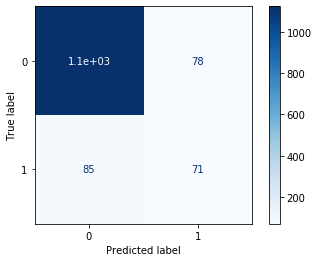

In [85]:
params={'colsample_bytree': 0.6790427788825881, 'gamma': 4.9437121904855585, 'learning_rate': 0.0686118272168518,
        'max_depth': 9.907799344685499, 'n_estimators': 456.4887419999514, 'subsample': 0.7791139392047272}

xg = xgb.XGBClassifier(objective='binary:logistic',nthread=4,n_jobs=4,params=params)
xg.fit(X1_train,y_train)
pred_xg = xg.predict(X1_test)
scores = xg.predict_proba(X1_test)[:,1]
plot_confusion_matrix(xg,X1_test,y_test,cmap = plt.cm.Blues)

As we can see our classifier is able to detect one class pretty high, but the detection in the second class is not that great. Fortunately we can easily solve this by varying threshold.

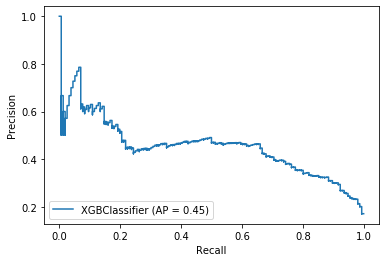

In [86]:
disp = plot_precision_recall_curve(xg, X1_test, y_test)
disp

Average precision score is quite low, but this is because of the fact that we do have an imbalanced data set, so that varying threshold can cause precision to take very low values.

AUC of ROC Curve: 0.8859177181408655


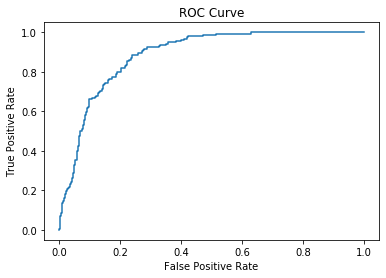

In [87]:
scores = xg.predict_proba(X1_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, scores)
roc_auc = roc_auc_score(y_test, scores)
print("AUC of ROC Curve:", roc_auc)
plt.plot(fpr, tpr)
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

ROC curve is among the best tools to determine the performance of classifier working on imbalanced dataset. As we can see our classifier peroform great. It is also worth noting, that if we want to raise precision or recall, we can simply adjust threshold, so that the classifier will fulfill our demands.

In [88]:
decisions = (xg.predict_proba(X1_test) >= 0.1).astype(int)[:,1]
print('Classification Report:\n',classification_report(y_test,decisions))

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.83      0.89      1201
           1       0.36      0.77      0.49       156

    accuracy                           0.82      1357
   macro avg       0.66      0.80      0.69      1357
weighted avg       0.90      0.82      0.84      1357



Setting threshold for very low value, as we see here 0.1, can easily improve detection on oure second class.

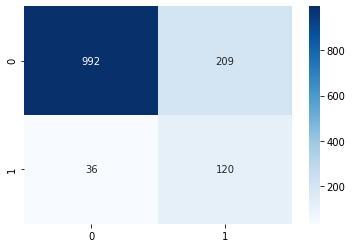

In [89]:
data = confusion_matrix(y_test,decisions)
sns.heatmap(data, cmap="Blues", annot=True,fmt='g')

# Stacking

As a final step we decided to stack our classifiers to make our predictions even better.

In [90]:
params = {'max_depth': 5, 'min_samples_leaf': 2,'min_samples_split': 2,'n_estimators': 1000,'max_features':'auto'}
estimators = [('logit', LogisticRegression(C=0.01,solver='saga',random_state=42)),
             ('svm',SVC(C=10)),
            ('tree',RandomForestClassifier(**params))]

In [91]:
params ={'colsample_bytree': 0.6790427788825881, 'gamma': 4.9437121904855585, 'learning_rate': 0.0686118272168518,
         'max_depth': 9.907799344685499, 'n_estimators': 456.4887419999514, 'subsample': 0.7791139392047272}
xg = xgb.XGBClassifier(objective='binary:logistic',nthread=4,n_jobs=4,params=params)
reg = StackingClassifier(estimators=estimators,final_estimator=xg)

In [92]:
reg.fit(X1_train,y_train)
preds = reg.predict(X1_test)
precision = precision_score(y_test,preds,average='weighted')
recall = recall_score(y_test,preds,average='weighted')
accuracy = accuracy_score(y_test,preds)
print(f"Precision: {precision}, recall: {recall}, accuracy: {accuracy}")

Precision: 0.8587953413843741, recall: 0.8680913780397936, accuracy: 0.8680913780397936


AUC of ROC Curve: 0.8337976899592221


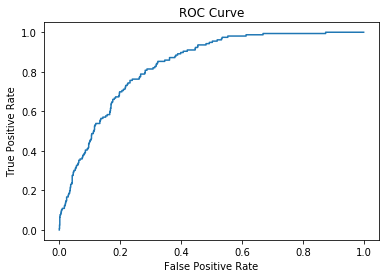

In [93]:
scores = reg.predict_proba(X1_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, scores)
roc_auc = roc_auc_score(y_test, scores)
print("AUC of ROC Curve:", roc_auc)
plt.plot(fpr, tpr)
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

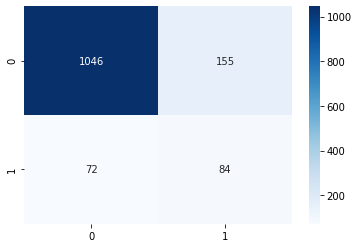

In [94]:
decisions = (reg.predict_proba(X1_test) >= 0.25).astype(int)[:,1]
data = confusion_matrix(y_test,decisions)
sns.heatmap(data, cmap="Blues", annot=True,fmt='g')

Unfortunately we did not manage to make our predictions better, so normal xgboost turned out to be our the best predictor.

## Features importances

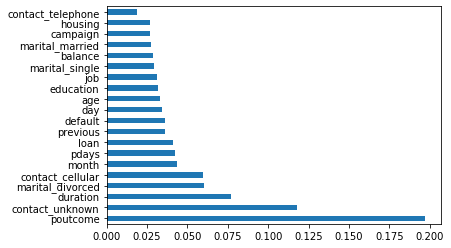

In [95]:

params = {'colsample_bytree': 0.8, 'gamma': 1.5, 'max_depth': 5, 'min_child_weight': 1, 
          'subsample': 0.8,'n_estimators':1000}
xg = xgb.XGBClassifier(objective='binary:logistic',nthread=4,n_jobs=4,params=params)
xg.fit(X1_train,y_train)
feat_importances = pd.Series(xg.feature_importances_, index=cols)
feat_importances.nlargest(20).plot(kind='barh')

Comparing feature importance scores with our conclusions from EDA, we can see that our predictions turned out to be true. Poutcome column which we assumed to have the biggest impact on predictions, indeed is the most important for our classfier. It makes for over 20% of our prediction which is huge considering the amount of columns that we have. It is also worth joting that contact column make for big part of our prediction, which come as a bit of a surprise, because during EDA we did not suppose, that it will have such a big impact. Fortunately we predicted that duration will have visible impact, but this is quite obvious that longer duration of a call may increase chances of positive outcome

# Over-sampling attempt
Trying over-sampling method to improve performance on imbalanced dataset.

In [96]:
#%pip install -U imbalanced-learn

Requirement already up-to-date: imbalanced-learn in /home/arctickey/anaconda3/lib/python3.7/site-packages (0.6.2)
Note: you may need to restart the kernel to use updated packages.


In [97]:
#SMOTE method works only for numeric values
X = pd.get_dummies(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42, stratify = y)

In [98]:
from imblearn.over_sampling import SMOTE

X_sampled, y_sampled = SMOTE().fit_resample(X_train, y_train)

### Training dataset now balanced

In [99]:
y_sampled.value_counts()

1    2999
0    2999
Name: y, dtype: int64

In [100]:
from sklearn.model_selection import RandomizedSearchCV

params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

model = xgb.XGBClassifier(objective='binary:logistic', n_estimators=600)

random_search = RandomizedSearchCV(model, param_distributions=params, scoring='roc_auc', n_jobs=4, 
                                   cv=5, verbose=3, random_state=42)

random_search.fit(X_sampled, y_sampled)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   43.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:  1.6min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n...
                                           subsample=None, tree_method=None,
                                           validate_parameters=False,
                                 

### Cross-validation performance
Model achived very good result during training

In [101]:
best_model = random_search.best_estimator_
prediction = best_model.predict(X_test)
random_search.best_score_

0.9835618530884809

### Test set score
However performance on test data did not improve.

In [102]:
print("Accuracy: ")
print(accuracy_score(y_test, prediction))
print("Recall: ")
print(recall_score(y_test, prediction))
print("Precision: ")
print(precision_score(y_test, prediction))

Accuracy: 
0.887709991158267
Recall: 
0.3923076923076923
Precision: 
0.5151515151515151


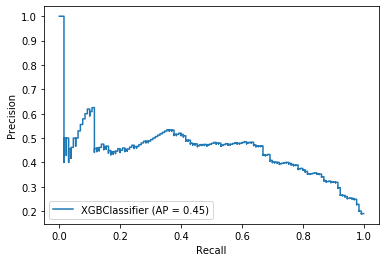

In [103]:
plot_precision_recall_curve(best_model, X_test, y_test)

AUC of ROC Curve: 0.8916007069853225


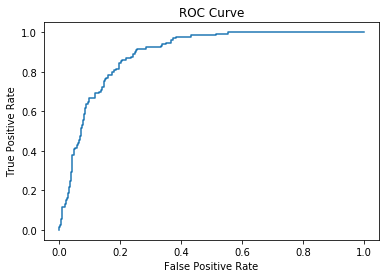

In [104]:
scores = best_model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, scores)
roc_auc = roc_auc_score(y_test, scores)
print("AUC of ROC Curve:", roc_auc)
plt.plot(fpr, tpr)
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

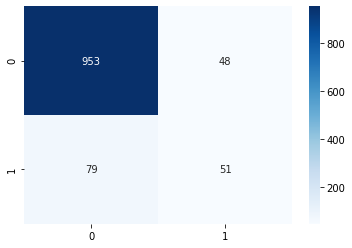

In [105]:
data = confusion_matrix(y_test,prediction)
sns.heatmap(data, cmap="Blues", annot=True,fmt='g')

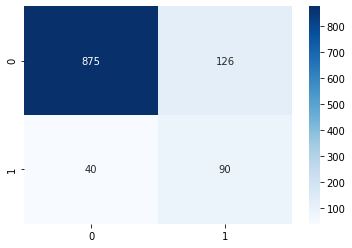

In [106]:
decisions = (best_model.predict_proba(X_test) >= 0.2).astype(int)[:,1]
data = confusion_matrix(y_test,decisions)
sns.heatmap(data, cmap="Blues", annot=True,fmt='g')